In [2]:
# pip install datasets pandas

In [8]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Convert to pandas DataFrame
df = dataset["train"].to_pandas()

In [9]:
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [10]:
print(df.columns)

# Check label distribution
print(df["label"].value_counts())

# map label if not already string
label_map = {0: "negative", 1: "neutral", 2: "positive"}
df["sentiment"] = df["label"].map(label_map)
df.drop(columns="label", inplace=True)

Index(['sentence', 'label'], dtype='object')
label
1    1391
2     570
0     303
Name: count, dtype: int64


In [12]:
df

,sentence,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
2259,Operating result for the 12-month period decre...,negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative
2261,LONDON MarketWatch -- Share prices ended lower...,negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load FinBERT model
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cpu


In [19]:
sample_sentences = df["sentence"].tolist()

# Run prediction
predictions = sentiment_pipeline(sample_sentences, truncation=True)

# Extract labels only
predicted_labels = [p["label"].lower() for p in predictions]

# Add to DataFrame
df["predicted_sentiment"] = predicted_labels
df.head()

,sentence,sentiment,predicted_sentiment
0,"According to Gran , the company has no plans t...",neutral,neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive
2,"In the third quarter of 2010 , net sales incre...",positive,positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive


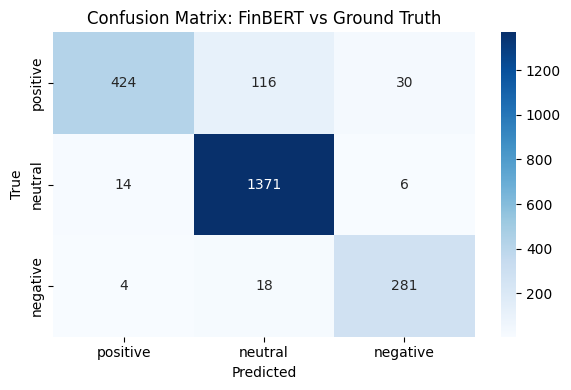

Accuracy: 91.70%


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Confusion matrix
cm = confusion_matrix(df["sentiment"], df["predicted_sentiment"], labels=["positive", "neutral", "negative"])
labels = ["positive", "neutral", "negative"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: FinBERT vs Ground Truth")
plt.tight_layout()
plt.show()

# Accuracy
accuracy = accuracy_score(df["sentiment"], df["predicted_sentiment"])
print(f"Accuracy: {accuracy:.2%}")

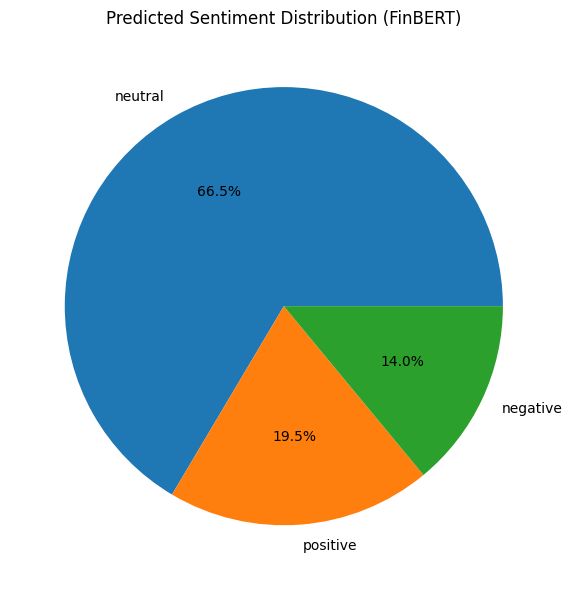

In [21]:
# Distribution of predicted sentiment
df["predicted_sentiment"].value_counts().plot.pie(
    autopct="%1.1f%%", figsize=(6, 6), title="Predicted Sentiment Distribution (FinBERT)"
)
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
import re

In [32]:
# Backup list of known company keywords (based on your dataset)
known_keywords = ["Componenta", "Talentum", "Seppälä", "Nokia", "Valmet", "Finnair", "UPM", "Kone", "Stora Enso", "Neste"]

def hybrid_extract_company(sentence):
    doc = nlp(sentence)

    # First try NER
    for ent in doc.ents:
        if ent.label_ == "ORG":
            name = ent.text.strip()
            if name.upper() not in false_positives and not re.match(r"^EUR|USD|\d", name):
                return name

    # If spaCy fails, try known keywords
    for keyword in known_keywords:
        if keyword.lower() in sentence.lower():
            return keyword

    return "Unknown"

df["company"] = df["sentence"].apply(hybrid_extract_company)
df[["sentence", "company"]].head(10)

,sentence,company
0,"According to Gran , the company has no plans t...",Unknown
1,"For the last quarter of 2010 , Componenta 's n...",Componenta
2,"In the third quarter of 2010 , net sales incre...",Unknown
3,Operating profit rose to EUR 13.1 mn from EUR ...,Unknown
4,"Operating profit totalled EUR 21.1 mn , up fro...",Unknown
5,Finnish Talentum reports its operating profit ...,Talentum
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,Unknown
7,Consolidated net sales increased 16 % to reach...,Consolidated
8,Foundries division reports its sales increased...,Machine Shop
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",AFX


In [33]:
# Group by company and count sentiment distribution
company_sentiment = df.groupby("company")["predicted_sentiment"] \
    .value_counts(normalize=True).unstack().fillna(0)

# Preview top companies
company_sentiment = company_sentiment.sort_values(by="positive", ascending=False)
company_sentiment.head(10)

predicted_sentiment,negative,neutral,positive
company,,,
Finnish Bank of +àland 's,0.0,0.0,1.0
Finnish Metso Minerals,0.0,0.0,1.0
Finnish Outokumpu Technology,0.0,0.0,1.0
Finnish Sampo Bank,0.0,0.0,1.0
Salomon,0.0,0.0,1.0
Bank of +àland 's,0.0,0.0,1.0
Baltic Beverages Holding,0.0,0.0,1.0
Fiskars Brands,0.0,0.0,1.0
YIT International Construction Services,0.0,0.0,1.0


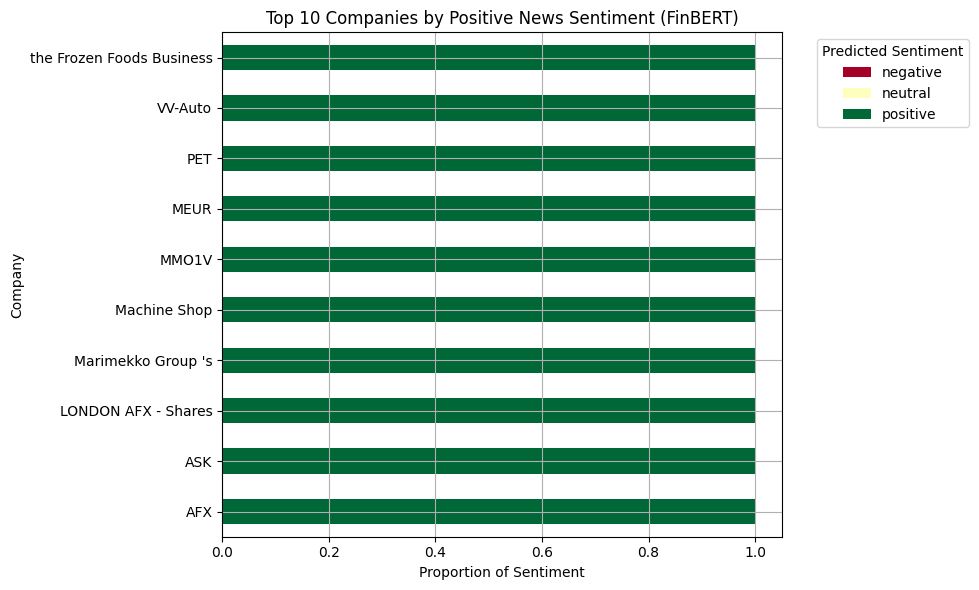

In [34]:
# Select top N companies with most positive sentiment
top_positive = company_sentiment.sort_values(by="positive", ascending=False).head(10)

# Plot
import matplotlib.pyplot as plt

top_positive.plot(kind="barh", stacked=True, figsize=(10, 6), colormap="RdYlGn")
plt.title("Top 10 Companies by Positive News Sentiment (FinBERT)")
plt.xlabel("Proportion of Sentiment")
plt.ylabel("Company")
plt.legend(title="Predicted Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

In [35]:
# Map sentiment to numeric score: negative=-1, neutral=0, positive=1
score_map = {"negative": -1, "neutral": 0, "positive": 1}
df["sentiment_score"] = df["predicted_sentiment"].map(score_map)

# Compute standard deviation per company
volatility = df.groupby("company")["sentiment_score"].std().fillna(0)
volatility = volatility.sort_values(ascending=False)

# Top 10 companies with the most sentiment variability
volatility.head(10)

,sentiment_score
company,
Okmetic Oyj,1.414214
YIT,1.154701
Componenta Oyj,1.154701
Consolidated,1.154701
Suominen Corporation,1.000000
Finnish Suominen Corporation,1.000000
Finnish Bank of +,0.957427
Talentum,0.894427
EPS,0.852803


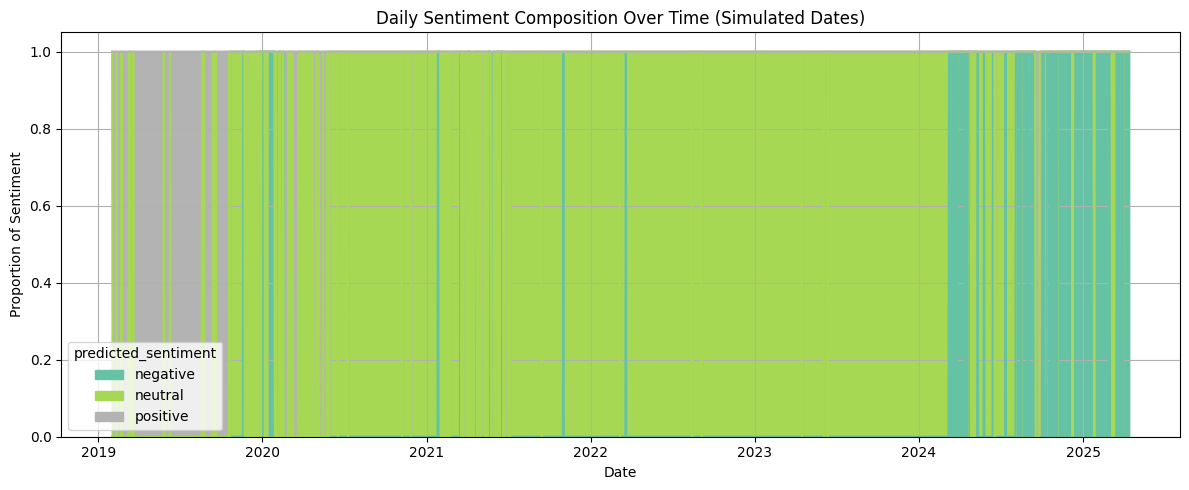

In [37]:
import numpy as np
import datetime

# Simulate time if not already present
df["date"] = pd.date_range(end=datetime.datetime.today(), periods=len(df))

# Group by day
daily_sentiment = df.groupby([df["date"].dt.date, "predicted_sentiment"]).size().unstack().fillna(0)

# Normalize per day
daily_sentiment_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0)

# Plot
import matplotlib.pyplot as plt
daily_sentiment_pct.plot(kind="area", stacked=True, figsize=(12, 5), cmap="Set2")
plt.title("Daily Sentiment Composition Over Time (Simulated Dates)")
plt.xlabel("Date")
plt.ylabel("Proportion of Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()

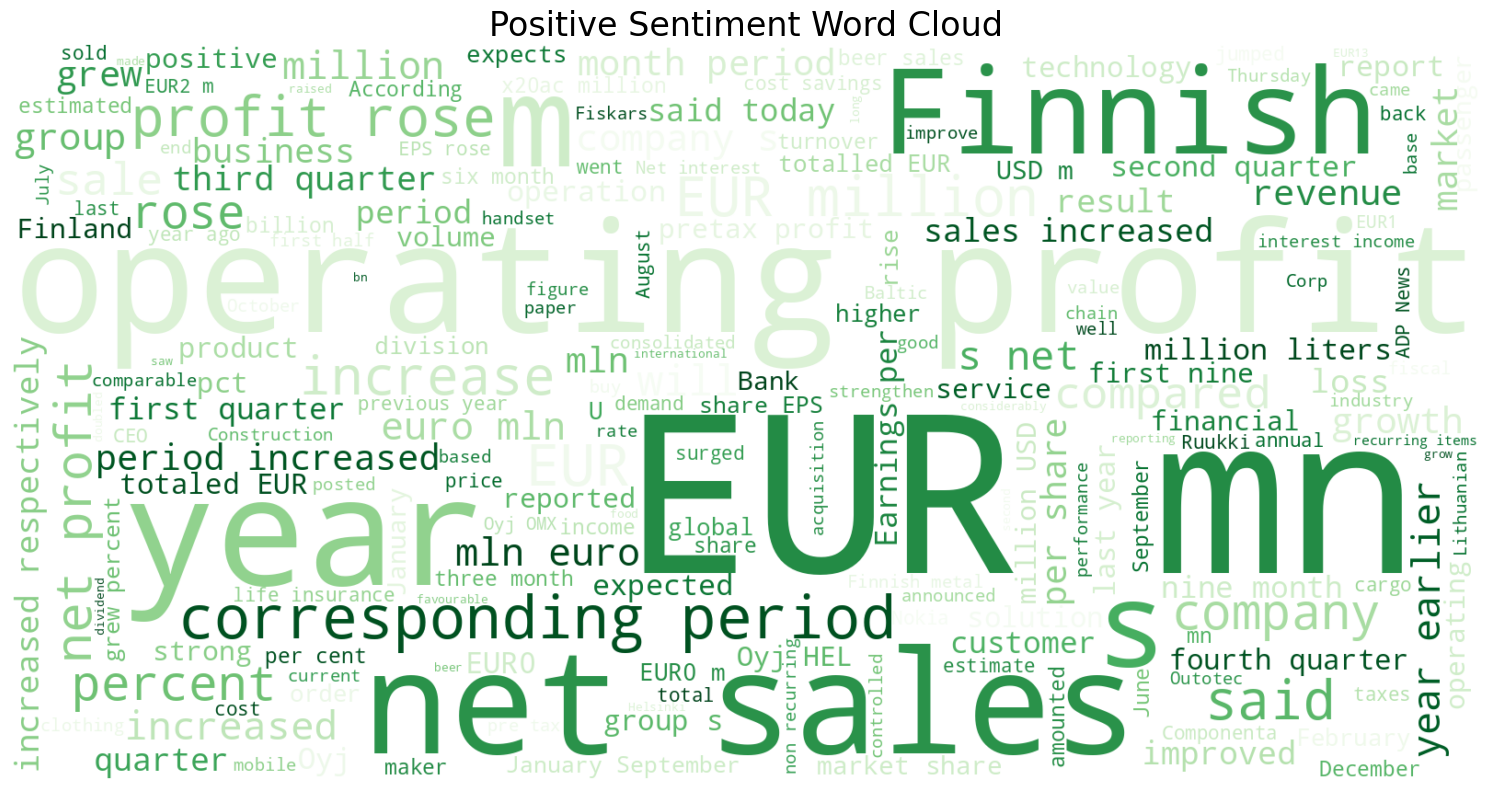

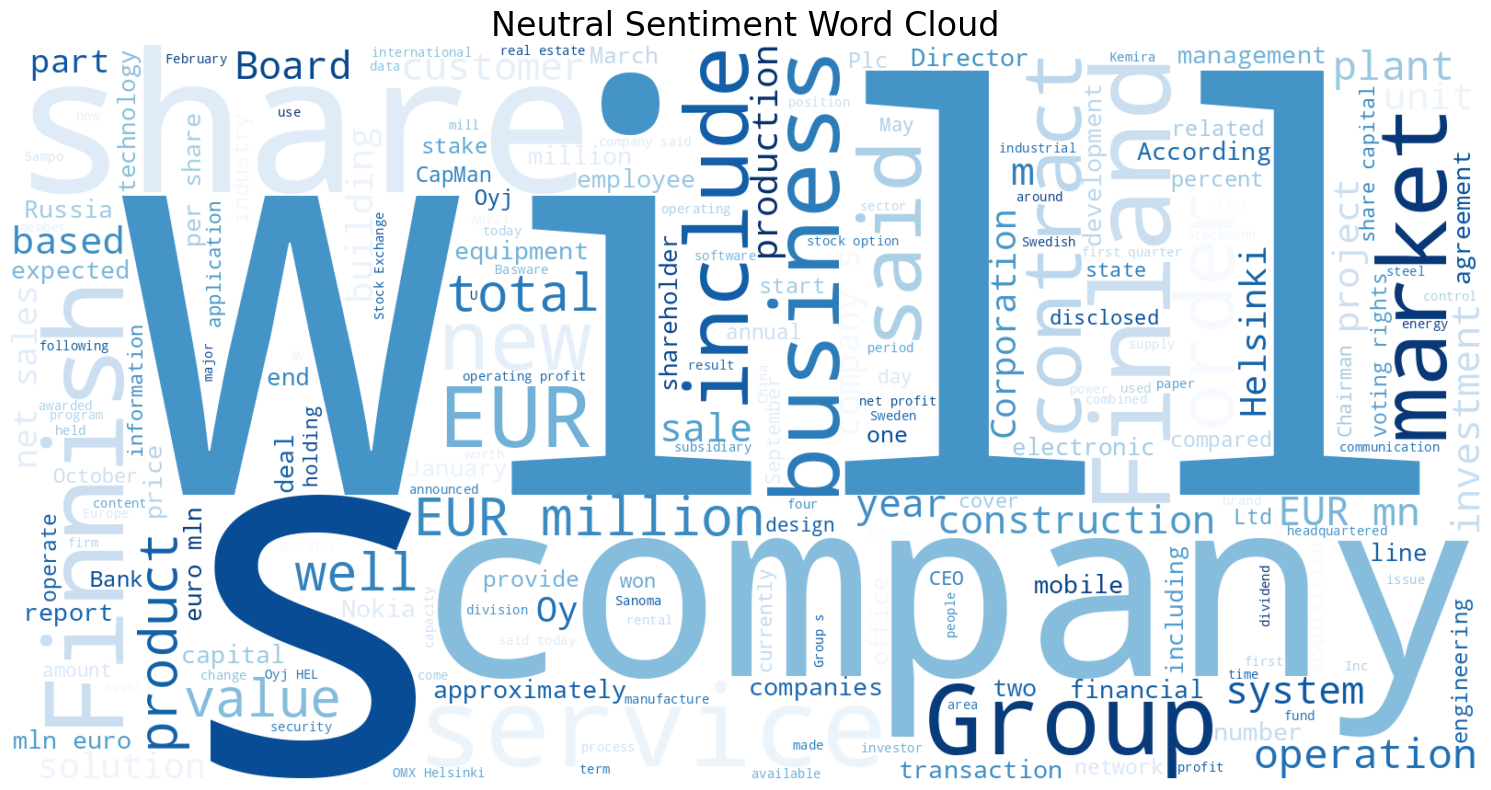

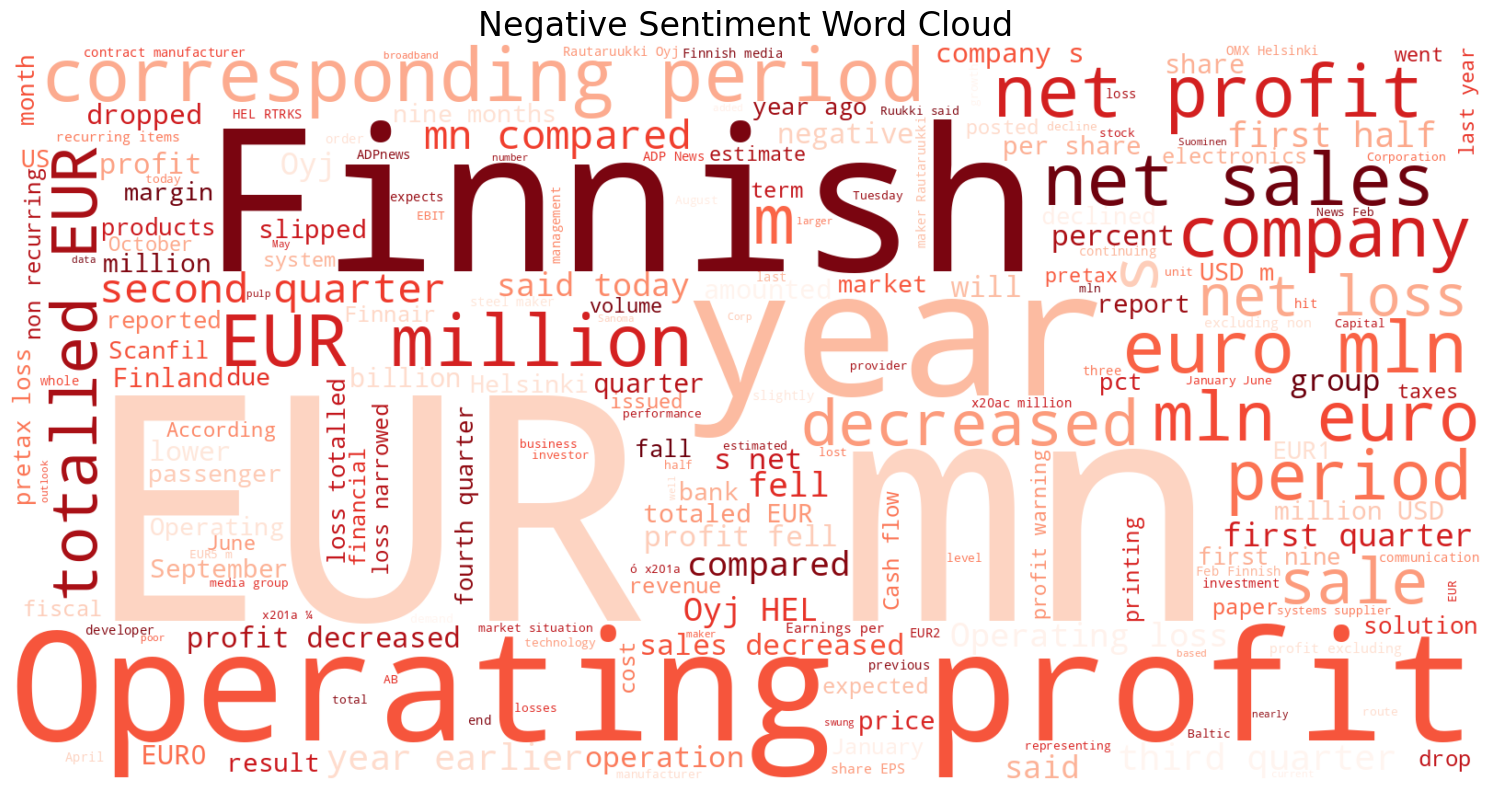

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Optional: Create a directory to save plots
import os
os.makedirs("plots", exist_ok=True)

# Define sentiment-to-colormap mapping
sentiment_colors = {
    "positive": "Greens",
    "neutral": "Blues",
    "negative": "Reds"
}

# Generate and save each word cloud individually
for sentiment, colormap in sentiment_colors.items():
    text = " ".join(df[df["predicted_sentiment"] == sentiment]["sentence"])

    wc = WordCloud(width=1600, height=800, background_color="white", colormap=colormap).generate(text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Sentiment Word Cloud", fontsize=24)
    plt.tight_layout()

    # Save each word cloud
    plt.savefig(f"plots/wordcloud_{sentiment}.png", dpi=300)
    plt.show()

In [50]:
from sklearn.model_selection import train_test_split

# Basic prep
X = df["sentence"]
y = df["sentiment"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build pipeline
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
baseline_model.fit(X_train, y_train)

# Predict
y_pred = baseline_model.predict(X_test)

              precision    recall  f1-score   support

    negative       0.94      0.59      0.73        56
     neutral       0.87      0.99      0.93       276
    positive       0.85      0.72      0.78       121

    accuracy                           0.87       453
   macro avg       0.89      0.77      0.81       453
weighted avg       0.87      0.87      0.86       453



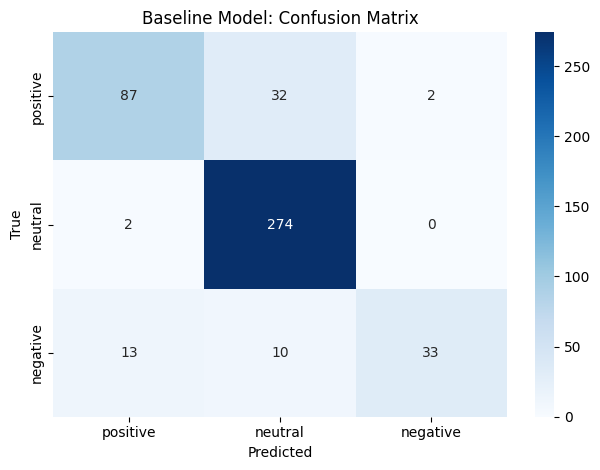

In [52]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"], cmap="Blues")
plt.title("Baseline Model: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [54]:
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

# Load original dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")["train"]

# The labels are already integers: 0=negative, 1=neutral, 2=positive
label_names = {0: "negative", 1: "neutral", 2: "positive"}

# Rename 'sentence' → 'text' for compatibility with Hugging Face Trainer
dataset = dataset.rename_column("sentence", "text")

# Split into train/val
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

# Confirm format
print(train_dataset[0])

{'text': "Koff 's market share of the volume of the market was 23.4 % , Karhu 's 21.4 % .", 'label': 1}


In [55]:
from transformers import AutoTokenizer

# Load FinBERT tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set dataset format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

In [56]:
from transformers import AutoModelForSequenceClassification

# Load model with correct number of labels (3 classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [59]:
from transformers import TrainingArguments, Trainer

# Define training configuration
training_args = TrainingArguments(
    output_dir="./finbert-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Optional: compute accuracy
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

In [60]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-60-23c3d7f9861e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajhnavi84 (ajhnavi84-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.655400,0.203442,0.944812
2,0.071800,0.281437,0.951435


Epoch,Training Loss,Validation Loss,Accuracy
1,0.655400,0.203442,0.944812
2,0.071800,0.281437,0.951435
3,0.014200,0.290757,0.949227


TrainOutput(global_step=681, training_loss=0.2471210238867044, metrics={'train_runtime': 8849.1739, 'train_samples_per_second': 0.614, 'train_steps_per_second': 0.077, 'total_flos': 357373799629056.0, 'train_loss': 0.2471210238867044, 'epoch': 3.0})

In [61]:
trainer.evaluate(val_dataset)

{'eval_loss': 0.2814374268054962,
 'eval_accuracy': 0.9514348785871964,
 'eval_runtime': 205.4514,
 'eval_samples_per_second': 2.205,
 'eval_steps_per_second': 0.277,
 'epoch': 3.0}

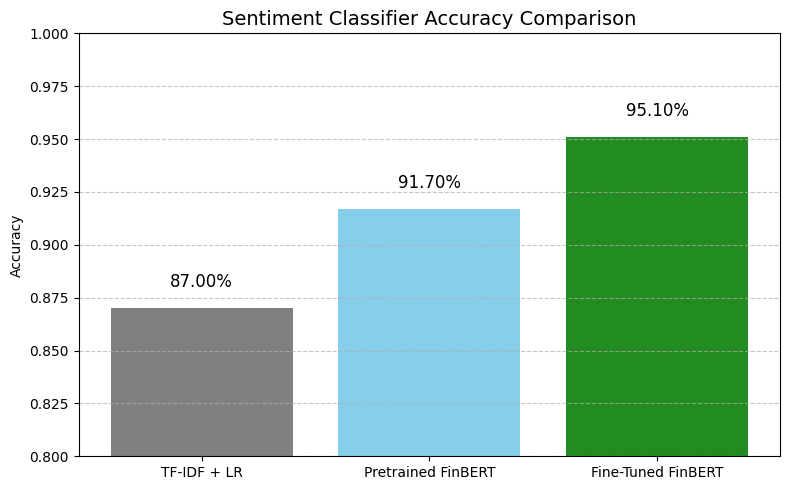

In [63]:
# Model names
models = ['TF-IDF + LR', 'Pretrained FinBERT', 'Fine-Tuned FinBERT']

# Corresponding accuracies (replace if you have updated values)
accuracies = [0.87, 0.917, 0.951]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['gray', 'skyblue', 'forestgreen'])

# Add labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', fontsize=12)

plt.title("Sentiment Classifier Accuracy Comparison", fontsize=14)
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()